<a href="https://colab.research.google.com/github/Many98/real_estate/blob/models/notebooks/XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

zkusit bez gp, price/m^2

In [195]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot
from matplotlib.pyplot import figure
from xgboost import plot_importance

#GET DATA & BASIC ANALYSIS

In [153]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('test_dataset.csv', sep=',', delimiter=None, encoding="utf8")
df_analysis = pd.read_csv('dataset.csv', sep=',', delimiter=None, encoding="utf8")
# drop indexes
df.drop(columns=df.columns[0], axis=1, inplace=True) 
df.describe()

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

In [154]:
# drop non-usable columns
df.drop("floor_area", axis=1, inplace=True) 
df.drop("desc_hash", axis=1, inplace=True) 
df.drop("hash", axis=1, inplace=True) 
# drop texts columns
df.drop("description", axis=1, inplace=True) # from nlp
df.drop("note", axis=1, inplace=True) # from nlp
df.drop("header", axis=1, inplace=True) # from nlp
df.drop("heating_txt", axis=1, inplace=True)
df.drop("waste_txt", axis=1, inplace=True)
df.drop("telecomunication_txt", axis=1, inplace=True)
df.drop("electricity_txt", axis=1, inplace=True)
df.drop("tags", axis=1, inplace=True)
df.drop("geometry", axis=1, inplace=True)
df.drop("additional_disposition", axis=1, inplace=True) 
df.drop("transport", axis=1, inplace=True) 
df.drop("name", axis=1, inplace=True) 
df.drop("place", axis=1, inplace=True) # praha 1 apod.
df.drop("date", axis=1, inplace=True) # later transform into float (2018+2/12)

In [155]:
# columns with embeddings
only_embeddings = [i for i in df.columns if 'emb' in i]
df = df.drop([emb for emb in only_embeddings], axis=1)
# only ordinal columns 
only_ord = [i for i in df.columns if 'ord' in i]
# columns with ordinal distance
only_ord_dist = [i for i in df.columns if 'dist' in i and 'ord' in i and 'num' not in i and 'city' not in i]
# only numerical dist columns (with indicator >=1500m)
only_num_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and 'num' in i and 'city' not in i] + \
                [i for i in df.columns if '1500m' in i]
# only one-hot encoded distances
only_one_hot_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and
                     'num' not in i and 'city' not in i]
only_one_hot_100m = [i for i in df.columns if '0-99m' in i]
# only coordinates
only_coords = ['long', 'lat']
# Gaussian process predicition
only_gp = [i for i in df.columns if 'gp' in i]
# noise
only_noise = [i for i in df.columns if 'noise' in i]
# quality
only_quality_ord = [i for i in df.columns if ('quality' in i or
                'sun' in i or 'built' in i) and 'ord' in i]
# one hotncoded energy effeciency
only_energy = [i for i in df.columns if 'energy_effeciency' in i and 'ord' not in i]
# disposition
only_disposition = [i for i in df.columns if 'disposition' in i]
# construction_type
only_construction = [i for i in df.columns if 'construction_t' in i]
# ownership
only_ownership = [i for i in df.columns if 'ownership' in i]
# equipment
only_equipment = [i for i in df.columns if 'equipment' in i]
# state
only_state = [i for i in df.columns if 'state' in i]
# only has_<> features
only_has = [i for i in df.columns if 'has' in i]

In [156]:
# e.g. when u want columns without embeddings and without ordinal features and without
#one-hot encoded ditances do something like that
df1 = df[df.columns.difference(only_embeddings + only_ord + only_one_hot_dist)]

In [157]:
df.head()

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

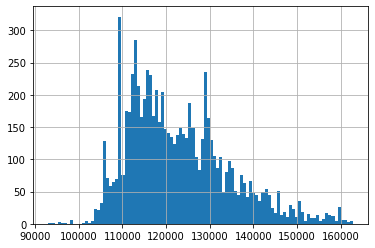

In [158]:
hist = df["gp_mean_price"].hist(bins=100)

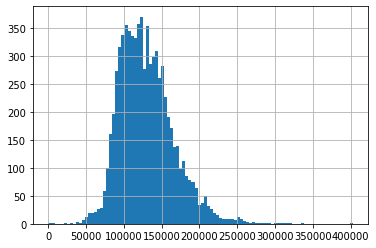

In [159]:
df['price_m2'] = df["price"]/df["usable_area"]
hist = df["price_m2"].hist(bins=100)

In [160]:
fig = px.box(df, y="gp_mean_price")
fig.show()

In [161]:
fig = px.box(df, y="price_m2")
fig.show()

In [162]:
df[df.price_m2 < 30000] # byty za 25000 a 23000 jenom? - Prodej podílu 1/345 bytu 3+kk 57 m² - inzerát: https://www.sreality.cz/hledani/prodej/byty/praha?cena-od=0&cena-do=25000

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

In [163]:
df[df.price_m2 > 400000] # https://www.sreality.cz/detail/prodej/byt/2+kk/praha-vysocany-podebradska/4035192396 - chyba v inzerátu

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

In [164]:
# keep flats > 35 000/m^2 and < 350 000/m^2
df = df[df.price_m2 > 40000]
df = df[df.price_m2 < 350000]

In [165]:
fig = px.box(df, y="price_m2")
fig.show()

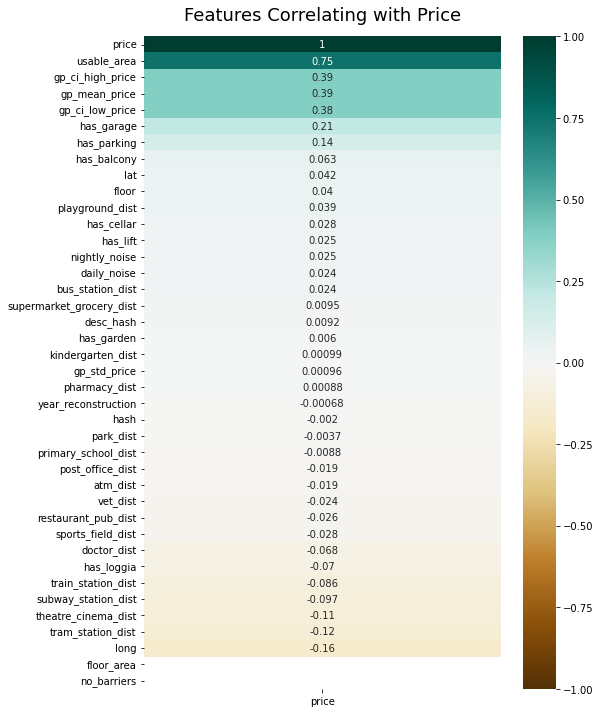

In [166]:
df_analysis.corr()[['price']].sort_values(by='price', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_analysis.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

In [171]:
# for error feature_names may not contain [, ] or <
df.columns = df.columns.str.replace(r'.', '_')
df.columns = df.columns.str.replace(r'-', '_')
df.columns = df.columns.str.replace(r'>=', '_vetsi_rovno_')
df.columns = df.columns.str.replace(r'+', '_plus_')
df.columns = df.columns.str.replace(r' ', '_')
df.columns = df.columns.str.replace(r'/', '_')
df.columns = df.columns.str.replace(r'[', '_')
df.columns = df.columns.str.replace(r']', '_')
df.columns = df.columns.str.replace(r'<', 'mensi')

In [167]:
df.drop("price_m2", axis=1, inplace=True)

#XGBoost

MODEL WITH ALL PARAMETRES

In [172]:
Y = df['price'].values.reshape(-1,1)
X = df.drop("price", axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [173]:
duplicate_columns = X.columns[X.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [186]:
basic_model = XGBRegressor()
basic_model.fit(X_train, Y_train)
y_pred = basic_model.predict(X_test)
predictions = [round(value) for value in y_pred]
print("The model training score is " , basic_model.score(X_train, Y_train))
print("The model testing score is " , basic_model.score(X_test, Y_test)) # 2500 pozorování
print("The model testing mean absolute error is ", mean_absolute_error(Y_test, y_pred))
print("The model max error is ", max_error(Y_test, y_pred))
print("The model median absolute error is ", median_absolute_error(Y_test, y_pred))

[21:54:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The model training score is  0.9027396862294992
The model testing score is  0.8283836467621052
The model testing mean absolute error is  1274429.1703020134
The model max error is  39078388.0
The model median absolute error is  729479.0


In [180]:
basic_model = XGBRegressor(n_estimators = 1500,
                        boosting_type='dart',
                        learning_rate=0.08999, 
                        colsample_bytree=0.96,
                        colsample_bynode=1,
                        #objective='reg:squarederror',
                        #eval_metric=mean_absolute_error,
                        max_depth=6,
                        #tree_method='hist',
                        #enable_categorical=True,
                        #subsample=0.9,
                        random_state=42, silent=True, 
                        #booster='gbtree',
                     
            early_stopping_rounds=20)
basic_model.fit(X_train, Y_train)
y_pred = basic_model.predict(X_test)
predictions = [round(value) for value in y_pred]
print("The model training score is " , basic_model.score(X_train, Y_train))
print("The model testing score is " , basic_model.score(X_test, Y_test)) # 2500 pozorování
print("The model testing mean absolute error is ", mean_absolute_error(Y_test, y_pred))
print("The model max error is ", max_error(Y_test, y_pred))
print("The model median absolute error is ", median_absolute_error(Y_test, y_pred))

The model training score is  0.999695373730957
The model testing score is  0.8419412603811579
The model testing mean absolute error is  1094815.4151006711
The model max error is  42932660.0
The model median absolute error is  589002.0


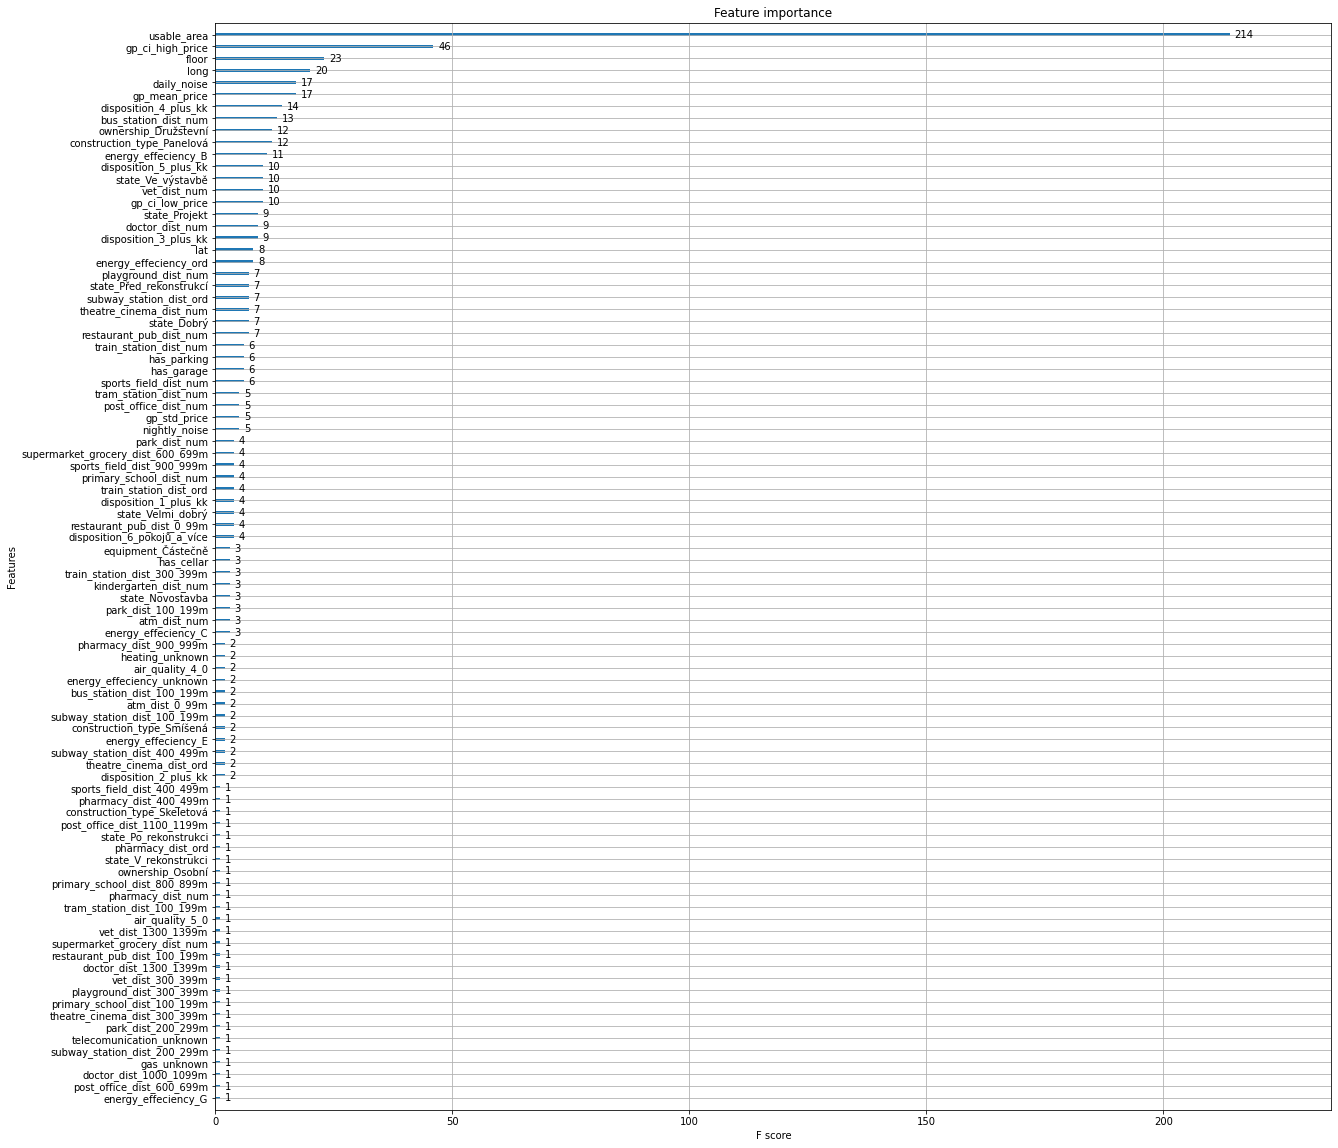

In [202]:
ax = plot_importance(basic_model)
fig = ax.figure
fig.set_size_inches(20,20)

MODEL with m^2 almost the same as with the price

MODEL with ord

In [ ]:
'''Y_cut = df_cut['price'].values.reshape(-1,1)
X_cut = df_cut.drop("price", axis=1)
X_cut = X_cut.drop([ord for ord in only_ord_dist], axis=1)
X_cut = X_cut.drop([ord for ord in only_one_hot_dist], axis=1)
X_train_cut, X_test_cut, Y_train_cut, Y_test_cut = train_test_split(X_cut, Y_cut, test_size=0.33, random_state=42, shuffle=True)'''

MODEL with onehot

MODEL with monotonic constrains

MODEL with target-encoding

RANDOM SEARCH

GRID SEARCH

BAYES. SEARCH